### **STEP TWO** OF DATA PROCESSING PIPELINE

#### This script imports all data that we sorted in step one and visualizes the data for each participant. ideally, this script and its plots should be used to perform visual inspection and start determining if some data was too noisy to be included. This script exports average contrast response functions for each participant.

### Upcoming goals 2/27/24: check if no saturation can be plotted

In [1]:
# load packages
import numpy as np 
import scipy.io
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

### Functions for Data Processing

In [2]:
def CleanRCA(x): # replace 0's in data with nan's
    x[x == 0] = np.nan
    return x
################################################################################
def CombineRealImg(x, NumHarms,NumBins,rca_roi,KeepHarms):
    """ 
    This function combines sin and cos soordinates. Specifically, per bin regardless of harmonic
    Data is feed as a NumBinsxNumHaems x [pre/post] 
    ie: 4 harmonics, 6 bins = [24 x 2] array, 8 CRF in total 
      """
    xIn = np.squeeze(x[:,rca_roi,:]) # acess the rca component of interest and combine cos and sin coordinates
    [HarmRows,NumTrials] = xIn.shape # 48 x 39
    #print(f'Number of Rows: {HarmRows}, Number of Trials: {HarmRows}')
    fft_thresh = int(HarmRows/2) # real and imaginary compoents 
    pre_post_thresh = int(NumTrials/2) # split all trials as pre and post
    #print(f'Real and Imaginary Boundary end at row : {fft_thresh}')
    #print(f'Trials will be split as pre post at col: {pre_post_thresh}')
    pre = xIn[:,:pre_post_thresh] # 48 x 39
    post = xIn[:,pre_post_thresh:] # 48 x 39

    AmpPerBin = np.zeros((NumHarms*NumBins,2))

    for ha in range(fft_thresh): # acess an array per harmonic indexing 
    # access single contrast across all trials and averge response 
        AmpPerBin[ha,0] = np.hypot(np.nanmean(pre[ha,:]),np.nanmean(pre[ha+fft_thresh,:])) # 12 x 78 PRE
        AmpPerBin[ha,1] = np.hypot(np.nanmean(post[ha,:]),np.nanmean(post[ha+fft_thresh,:])) # 12 x 78 POST
    # # just to double check s
    # plt.plot(AmpPerBin[:,0],label = 'pre')
    # plt.plot(AmpPerBin[:,1], label = 'post')
    # for i in range((fft_thresh)):
    #     if i % 6 == 0:  # Check if the index is divisible by 6
    #         plt.axvline(x=i, color='b', linestyle='--')  # Plot a vertical line at this index
    IndAmpPerBin = np.zeros((int(len(KeepHarms))*NumBins,2))
    for k in range(len(KeepHarms)):
        BinIn = KeepHarms[k]
        s = (BinIn*NumBins)
        e = s + (NumBins)
        #print(f'start: {s}, end: {e}')
        IndAmpPerBin[s:e,:] = AmpPerBin[s:e,:]
    
    return IndAmpPerBin#AmpPerBin, IndAmpPerBin

In [3]:
NumBins = 6 # number of contrasts
NumHarms = 2#2 # number of harmonic data: 2F1, 4F1
NumConds = 4
dk_labs = ['attnL F1','attnL F2','attnR F1','attnR F2',]
contrast_levels=np.array([1, 3, 5, 16, 40, 100])
contrast_levels_labs=['1%', '3%', '5%', '16%', '40%', '100%']

In [4]:
x = sns.color_palette("husl", 8)
y = sns.color_palette("hls", 8)

In [5]:
# Main Directory of processed file from MatLab
# MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AllSubjSweepRCA\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\AllSubjSweepRCA\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[0] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['AllSessionDataCombin_allHarms_20240401_110553.pkl']
Current WD: C:\plimon\LTP_analysis\RCA_F1\AllSubjSweepRCA\AllSessionDataCombin_allHarms_20240401_110553.pkl
Does File #1 Exist? True


In [6]:
# SaveFigDir = 'D:\\AttnXV3_analysis\\TwoSessionPlots_LTP\\'
SaveFigDir = 'C:\\plimon\\LTP_analysis\\TwoSessionPlots_LTP\\'
SubFoldName = 'CRF_plots' # can change folder name to add to another folder now
newPath = os.path.join(SaveFigDir,SubFoldName)
if not os.path.exists(newPath):
    os.makedirs(newPath)
print('Path to Save Figures is:',newPath)

Path to Save Figures is: C:\plimon\LTP_analysis\TwoSessionPlots_LTP\CRF_plots


In [7]:
loadData = pkl.load(open(file_path1, 'rb'))
print(loadData.keys())

dict_keys([0, 1])


In [8]:
print(f'Data for double session subs')
print(loadData[0].keys())
print(f'Data for single session subs')
print(loadData[1].keys())

Data for double session subs
dict_keys([0, 1, 2, 3, 'FullSessSubjNames', 'DataNotes'])
Data for single session subs
dict_keys([0, 1, 2, 3, 'AttnLSubNames', 'AttnRSubNames'])


### Extract Double Session Data + other important info

In [9]:
TwoSessData = loadData[0]
#print(loadData[0].keys())

In [10]:
SubName = TwoSessData['FullSessSubjNames'] # suject names
NumSubs = int(len(SubName)) # number of participants 
txt = TwoSessData['DataNotes'] # notes from file imported
data2s_inds = list(TwoSessData.keys())[0:4]
data_2s = {key: TwoSessData[key] for key in data2s_inds}
print(data_2s.keys())

dict_keys([0, 1, 2, 3])


### Extract Single Session Data + other important info

In [11]:
SingleSessData = loadData[1]
#print(loadData[1].keys())

In [12]:
# import actual data 
data_1s_inds = list(SingleSessData.keys())[0:4]
data_1s = {key: SingleSessData[key] for key in data_1s_inds}
print(data_1s.keys())
# Name subs who completed attnL only + counts
attnLSubs = SingleSessData['AttnLSubNames']
NumSubs_l = int(len(attnLSubs))
print(attnLSubs, NumSubs_l)
# Name subs who completed attnR only + counts
attnRSubs = SingleSessData['AttnRSubNames']
NumSubs_r = int(len(attnRSubs))
print(attnRSubs, NumSubs_r)

dict_keys([0, 1, 2, 3])
['2660' '2708' '2715' '2716' '2727' '2733' '2734'] 7
['2663' '2663' '2676' '2678' '2726'] 5


#### 1.1| Remove NaNs from RCA Data

In [13]:
data_out = {} # double session subjects
for data_set_ind in range(NumConds):
    data_out[data_set_ind] = {}  # Initialize inner dictionary for data_set_ind
    for i in range(NumSubs):
        # a dict of 4 with XSubs dict keys of data
        data_out[data_set_ind][i] = CleanRCA(np.array(data_2s[data_set_ind][i]))

In [14]:
data_out_1Sess = {} # single session subjects
for i in range(NumConds):
    data_out_1Sess[i] = {}
    if i == 0 or i == 1: 
        NSubs = NumSubs_l
    else:
        NSubs = NumSubs_r
    for j in range(NSubs):
        data_out_1Sess[i][j] = CleanRCA(np.array(data_1s[i][j]))

#### 1.2| Combine Real and Imaginary Data and Save

In [15]:
avgCRF = {} # double session subjects
for co in range(NumConds):
    avgCRF[co] = {}  # Initialize inner dictionary for data_set_ind
    for i in range(NumSubs):
        dIn = np.array(data_out[co][i])
        avgCRF[co][i] = CombineRealImg(x = dIn,NumHarms = 4,NumBins = 6, rca_roi = 0, KeepHarms = [0,1,2,3])

In [16]:
avgCRF_1Sess = {} # single session subjects
for co in range(NumConds):
    avgCRF_1Sess[co] = {}
    if co == 0 or co == 1: 
        NSubs = NumSubs_l
    else:
        NSubs = NumSubs_r
    for i in range(NSubs):
        dIn = np.array(data_out_1Sess[co][i])
        avgCRF_1Sess[co][i] = CombineRealImg(x= dIn,NumHarms = 4,NumBins = 6, rca_roi = 0,KeepHarms = [0,1,2,3]) # 12 x 2 array

In [17]:
# set save data dir 
# Set directory to save NR Data in ..new folder
# SaveDataDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir where files (.pkl, .csv) will be saved
SaveDataDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\AvgCRFs\\' # set dir where files (.pkl, .csv) will be saved
FileOutName = 'AllCondCRF_AllHarmonics_clean2468f' # make sure this file changes each time you save
######################################################
dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M") # set the above as a string ...
FileN = f'{FileOutName}_{fdnt}.pkl' 
# MatLabFileN = f'{FileOutName}_{fdnt}.mat'

NewFileNPath = os.path.join(SaveDataDir,FileN)
# Mat_NewFileNPath = os.path.join(SaveDataDir, MatLabFileN)

print('Full New File Dir: ', NewFileNPath)
#print('Where matlab file will be stored',Mat_NewFileNPath )

if not os.path.exists(SaveDataDir):
    os.makedirs(SaveDataDir)
print('Path to Save File is:',SaveDataDir)

Full New File Dir:  C:\plimon\LTP_analysis\RCA_F1\AvgCRFs\AllCondCRF_AllHarmonics_clean2468f_20240401_1445.pkl
Path to Save File is: C:\plimon\LTP_analysis\RCA_F1\AvgCRFs\


##### Save All Original Contrast Response Functions into a .pkl file

In [18]:
# add another personal voice memo ...
Note = ['This file contains all subjects [single and double] sessions, avg of CRF [12x2] array, original crfs']

DictOut = {}
DictOut['Data'] = avgCRF # double session data
DictOut['SubNames'] = SubName # subject names

DictOut['DataSingleSess'] = avgCRF_1Sess # single session data
DictOut['DSSAttnl'] = attnLSubs
DictOut['DSSAttnR'] = attnRSubs

DictOut['VoiceMemo'] = Note # personal note about data
DictOut['DictMainKeys'] = dk_labs
DictOut['ContLevs'] = contrast_levels
DictOut['crfLabs'] = contrast_levels_labs

### Save Data

In [19]:
saveFile = 'y'

if saveFile == 'y':
 
 #scipy.io.savemat(Mat_NewFileNPath,DictOut)

 with open(NewFileNPath, 'wb') as file:
    pkl.dump(DictOut, file, protocol=pkl.HIGHEST_PROTOCOL)
    # save as .mat file or .csv file to import into matlab 
    
    print('Average CRF Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')

Average CRF Saved! :))


#### Visualize Data - can only plot per harmonic right now 

In [20]:
harmonic_label =  ['2','4','6','8']
co_lab = ['Attention Left, Attended F1','Attention Left, Unattended F2','Attention Right, Unattended F1','Attention Right, Attended F2']

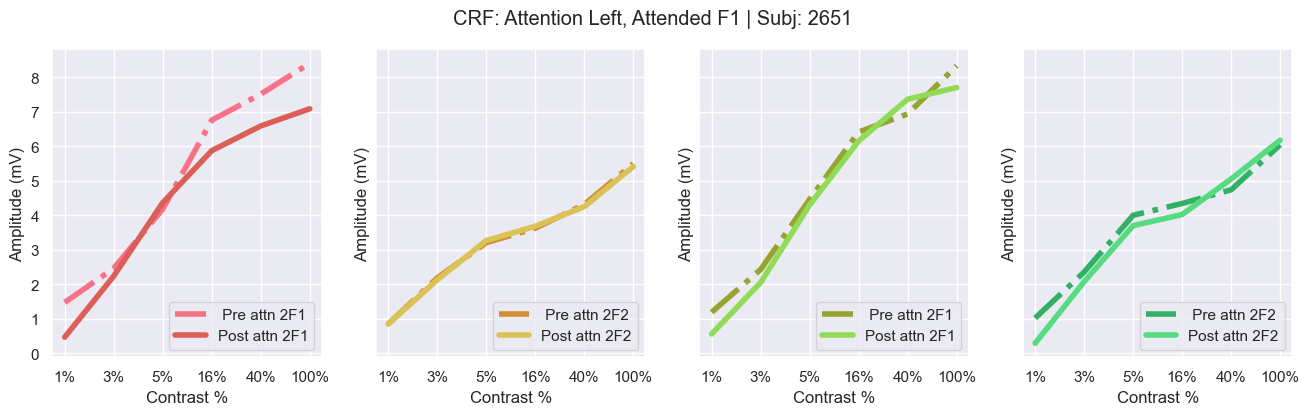

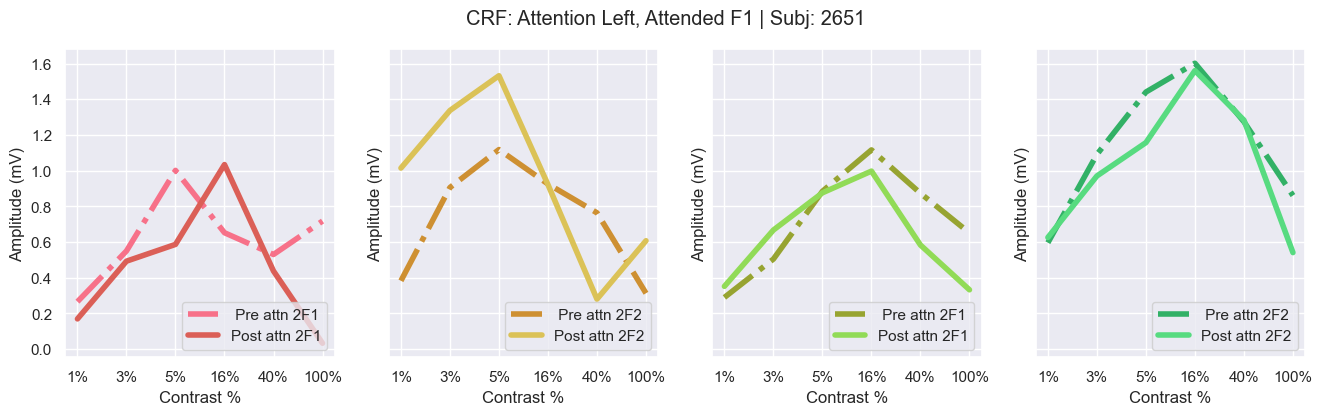

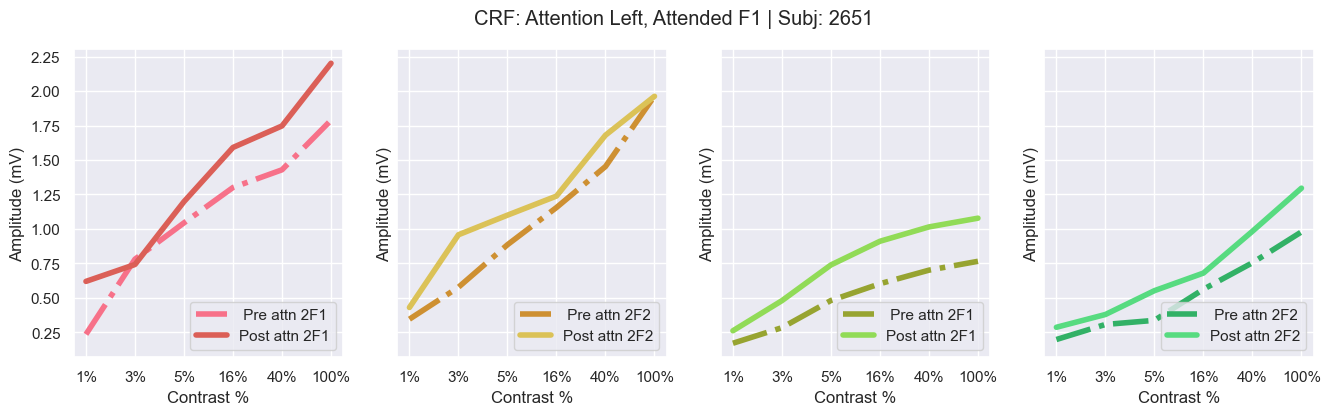

In [30]:
sns.set_theme()
dpi = 150 # img res

HarmInd = NumBins

for sub_ind in range(3):# NumSubs
    fig, axs = plt.subplots(1,4,figsize = (16,4), sharey = True )
    for c in range(NumConds):

        t_lab = str(dk_labs[c])
        co_l = t_lab[0:4]
        harm_l = t_lab[6:]
        ImgName = (f'Sub_{SubName[sub_ind]}_data2F_.png')
        axs[c].plot(avgCRF[c][sub_ind][0+HarmInd:6+HarmInd,0], label = f' Pre {co_l} {harmonic_label[h]}{harm_l}', color = x[c], linewidth = 4, linestyle = '-.')
        axs[c].plot(avgCRF[c][sub_ind][0+HarmInd:6+HarmInd,1], label = f'Post {co_l} {harmonic_label[h]}{harm_l}', color = y[c], linewidth = 4)
        axs[c].set_xlabel('Contrast %')
        axs[c].set_ylabel('Amplitude (mV)')
        axs[c].legend(loc = 'lower right')
        axs[c].set_xticks(range(len(contrast_levels_labs)))
        axs[c].set_xticklabels(contrast_levels_labs)
        plt.suptitle(f'CRF: {co_lab[h]} | Subj: {SubName[h]}')
        #ImgPath = os.path.join(newPath, ImgName)
        #plt.savefig(ImgPath, dpi = dpi)
    plt.show()

#### Vis Single Sessions

In [31]:
# sns.set_theme()
# dpi = 150 # img res
# for sub_ind in range(0):
#     fig, axs = plt.subplots(1,2,figsize = (8,4), sharey = True )
#     for c in range(2):
#         #ImgName = (f'Sub_{attnLSubs[sub_ind]}_data2F_.png')

#         axs[c].plot(avgCRF_1Sess[c][sub_ind][12:18,0], label = f' Pre {dk_labs[c]}', color = x[c], linewidth = 4, linestyle = '-.')
#         axs[c].plot(avgCRF_1Sess[c][sub_ind][12:18,1], label = f'Post {dk_labs[c]}', color = y[c], linewidth = 4)

#         axs[c].set_xlabel('Contrast %')
#         axs[c].set_ylabel('Amplitude (mV)')
#         axs[c].legend(loc = 'lower right')
#         axs[c].set_xticks(range(len(contrast_levels_labs)))
#         axs[c].set_xticklabels(contrast_levels_labs)
#         plt.suptitle(f'CRF For single sessions, attnL (1st Harmonic), Sub: {attnLSubs[sub_ind]}')
#         #ImgPath = os.path.join(newPath, ImgName)
#         #plt.savefig(ImgPath, dpi = dpi)
#     plt.show()

In [34]:
# for sub_ind in range(NumSubs_r):
#     fig, axs = plt.subplots(1,2,figsize = (8,4), sharey = True )
#     for c in range(2):
#         ImgName = (f'Sub_{attnRSubs[sub_ind]}_data2F_.png')

#         axs[c].plot(avgCRF_1Sess[c+2][sub_ind][:6,0], label = f' Pre {dk_labs[c+2]}', color = x[c+2], linewidth = 4, linestyle = '-.')
#         axs[c].plot(avgCRF_1Sess[c+2][sub_ind][:6,1], label = f'Post {dk_labs[c+2]}', color = y[c+2], linewidth = 4)

#         axs[c].set_xlabel('Contrast %')
#         axs[c].set_ylabel('Amplitude (mV)')
#         axs[c].legend(loc = 'lower right')
#         axs[c].set_xticks(range(len(contrast_levels_labs)))
#         axs[c].set_xticklabels(contrast_levels_labs)
#         plt.suptitle(f'CRF For single sessions, attnR (1st Harmonic), Sub: {attnRSubs[sub_ind]}')
#         #ImgPath = os.path.join(newPath, ImgName)
#         #plt.savefig(ImgPath, dpi = dpi)
#     plt.show()